# 图像特效-CRTFilter

In [1]:
from scipy import signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.lib.function_base import histogram

In [2]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.imread('../datas/f2.jpg',0)

In [3]:
def smoothstep(mmax,mmin,value):
    z = np.zeros_like(mmin)
    x = np.maximum(0, np.minimum(1, (value-mmin)/(mmax-mmin + 1.0e-5)))
    return x*x*(3 - 2*x)

In [10]:
def crt_filter(src):
    srcf = np.float32(src)
    dst = np.zeros_like(srcf)
    phosphor_bleed = 0.78
    phosphor_bloom = np.zeros((256,))
    phosphor_bloom_linspace = np.zeros_like(phosphor_bloom)
    scale_add = 1.0
    scale_times = 0.8
    scan_lower_limit = 0.6
    scan_range = np.zeros_like(phosphor_bloom)
    scan_upper_limit = 0.
    
    phosphor_bloom_linspace = np.arange(0,256) / 255.0
    phosphor_bloom = scale_times * phosphor_bloom_linspace
    current = scan_lower_limit
    step = (scan_upper_limit - scan_lower_limit) / 256
    for i in range(256):
        current += step
        scan_range[i] = current
        
    rows,cols = src.shape[0],src.shape[1]
    current_pixel_data = None
    previous_pixel_data = None
    for y in range(1,rows):
        for x in range(1,cols):
            current_pixel_data = srcf[y,x]
            if y % 2 == 0:
                red = current_pixel_data[0]
                if x % 2 == 1:
                    previous_pixel_data = srcf[y,x-1]
                    if previous_pixel_data[0] > 0:
                        red = previous_pixel_data[0] * phosphor_bleed * phosphor_bloom[int(previous_pixel_data[0])]
                green = current_pixel_data[1]
                if green > 0:
                    green = green / 2 + (green / 2) * phosphor_bleed * phosphor_bloom[int(current_pixel_data[1])]
                blue = current_pixel_data[2]
                if x % 2 == 1:
                    blue = blue * phosphor_bleed * phosphor_bloom[int(previous_pixel_data[2])]
                dst[y,x] = (red,green,blue)
            else:
                previous_pixel_data = srcf[y-1,x]
#                 print(previous_pixel_data)
                red = scan_range[int(previous_pixel_data[0])] * previous_pixel_data[0]
                green = scan_range[int(previous_pixel_data[1])] * previous_pixel_data[1]
                blue = scan_range[int(previous_pixel_data[2])] * previous_pixel_data[2]
                dst[y,x] = (red,green,blue)
    return dst

In [11]:
dst = crt_filter(src)

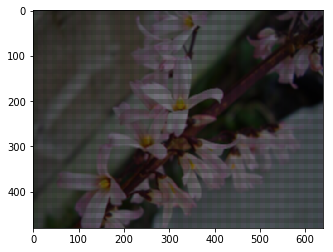

In [17]:
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = dst.astype(np.uint8)
plt.imshow(cv2.GaussianBlur(dst,(5,5),2.4))